<h1 align="center">2D MOT</h1>

In [1]:
%reset
#### Constants ##############################################################################
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
%matplotlib inline
# Constants =================================================================================
NA = 6.023*10**23;
mu_B = 9.274009994*10**-24*10**-4;  #[Joule per Gauss]
kB = 1.38064852*10**-23;            #[Joule per Kelvin]
h = 6.626070040*10**-34;            # Planck's constant [Js]
lamda = 589*10**-9;                 # Wavelength [nm]
M = 22.9;                           # Mass of NA atoms [g]
M_Li = 6.941;                       # Mass of NA Lithium atoms [g]
M_Rb = 85.47;                       # Mass of NA Rubidium atoms [g]
sigma_el = 6*10**-12*10**-4;        #[m^2]
gamma = 2*np.pi*9.7946;             # Natural line width [MHz]
Isat = 6.26;                        # Saturation Intensity for F = 2 to F = 3 [mW/cm^2]
ZSplit_cool = 1.39;                 # Detuning due to hyperfine splitting for cooling transition [MHz/G]
ZSplit_repump = 1.63;               # Detuning due to hyperfine splitting for repump transition [MHz/G]

hbar = h/(2*np.pi);                 # Reduced Planck's constant [Js]
k = 2*np.pi/lamda;                  # Wave vector [m-1]
m = M*10**-3/NA;                    # Mass of one atom [kg]
m_Li = M_Li*10**-3/NA;              # Mass of one Lithium atom [kg]
m_Rb = M_Rb*10**-3/NA;              # Mass of one Lithium atom [kg]

# Global Functions
def find_nearest_index(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

del(M,NA)


############## 2D MOT Parameters ======================================================
# 2D MOT geometrical parameters =======================================================
L = 3.5*25.4*10**-3;                # Distance between nozzle opening and MOT center [m]
Dnozzle = (3/8-0.1)*25.4*10**-3;    # Nozzle Aperture Inner Diameter [m]
Lnozzle = 2.5*25.4*10**-3;          # Nozzle Length [m]
Anozzle = np.pi*(Dnozzle/2)**2;     # Nozzle Aperture Area [m^2]
L_m2m = 10*25.4*10**-3;             # Distance between 2D MOT to 3D MOT [m]
# Laser beam ===========================================================================
Rmot = 7.49*10**-1;                 # Radius of MOT beams [cm]
Rzs = 3.66*10**-1;                  # Slower Beam radius [cm]
Rpush = 1*10**-1;                   # Push beam radius [cm]
Det_slow = -230;                    # Cooling Detuning [MHz]
Det_cool = -20                      # Detuning of the beams [MHz]
Det_repump = 0                      # Detuning of the beams [MHz]
Det_push = +10                      # Detuning of the beams [MHz]
Power_slow = 90;                    # Power of slowing beam [mW]
Power_cool = 20;                    # Power of each beam [mW]
Power_repump = 80;                  # Power of each beam [mW]
Power_push = 70*10**-3;             # Power of push beam [mW]
# Others ===============================================================================
Toven = 200;                        # Oven Tenperature [C]
FieldGrad = 36                      # MOT field gradient [G/cm]
# Derived Quantities ===================================================================
beta = ZSplit_cool*FieldGrad*100*10**6*2*np.pi # Zeeman shift [s^-1*m^-1]

from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Table of Contents

<ul>
  <li><a href='#A'>Introduction</a> </li>
    <li><a href='#B'>Types of Sources for Cold Atom Experiments</a> </li>
    <li><a href='#C'>ErNa's Sodium 2D MOT setup</a> </li>
    <li><a href='#C1'>Radial Capture Velocity of 2D MOT</a> </li>
    <li><a href='#C2'>Slowing with just the repump beam</a> </li>
    <li><a href='#C3'>Slowing action of Slower</a> </li>
    <li><a href='#C4'>Push Beam Action</a> </li>
</ul>


<a id="A"></a>
# Introduction
Bose-Einstein Condensates (BEC) preparation involves cooling a gaseous ensemble of atoms from above room temperature to almost absolute zero. To achieve phase-space densities corresponding to BEC, one needs to minimize atoms lost during the cooling process. A multi-stage cooling scheme helps doing so. The various cooling steps can be broadly categorized as $\textbf{laser cooling}$ and $\textbf{forced evaporation}$ with laser cooling as the first step. Forced evaporation techniques are very lossy. Therefore one needs to start with a large atom number in the laser cooling stages (typically 1 B) to ensure a decent phase space density at the very end. 

A prerequisite for making a BEC is having a source capable of producing a $\textbf{high flux of cold atoms}$. A 3-dimensional Magneto-Optical Trap (MOT) traps these atoms. The depth of this 3D MOT sets a limit on the temperature of atoms that can be captured. Once in the 3D MOT, atoms are cooled further before being transferred to a purely magnetic trap to perform various forms of evaporative cooling. 

A measure of 3D MOT trap depth is its capture velocity. Typical capture velocities of 3D MOTs are less than 100m/s. As a result, the first stage of cooling should be capable of cooling a sufficiently large number  (typically 1 B)  of atoms to a temperature below the 3D MOT trap depth. To understand the challenge involved, we look at the velocity distribution of atomic flux of the sodium atoms at three different temperatures. 

The figure below shows that the velocity distribution of atoms is centered far away from typical 3D MOT capture velocities. Naively one might think of reducing the temperature of the atoms to center the velocity distribution to lower velocities. But as can be seen from the curve below, the atomic flux drops dramatically from 150$^o$C to 230$^o$C. The mean velocity, in this case, reduces from 681 to just 625 m/s.

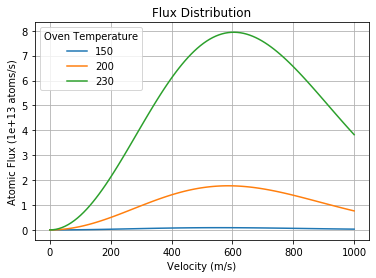

In [3]:
# Maxwell Boltzmann
N = 100;

T1 = 150+273;
P1 = 133.322*10**(2.881+4.704-5377/T1); # Vapor Pressure [Pa]
n1 = P1/(kB*T1); # Number density of atoms [atoms/m^3]
v1 = np.sqrt(8*kB*T1/(np.pi*m)); # Mean velocity of atoms [m/s]
Flux1 = (8*(Dnozzle/2)/(3*Lnozzle))*n1*v1*Anozzle; # Atomic Flux [atoms/s]
T2 = 200+273;
P2 = 133.322*10**(2.881+4.704-5377/T2); # Vapor Pressure [Pa]
n2 = P2/(kB*T2); # Number density of atoms [atoms/m^3]
v2 = np.sqrt(8*kB*T2/(np.pi*m)); # Mean velocity of atoms [m/s]
Flux2 = (8*(Dnozzle/2)/(3*Lnozzle))*n2*v2*Anozzle; # Atomic Flux [atoms/s]
T3 = 230+273;
P3 = 133.322*10**(2.881+4.704-5377/T3); # Vapor Pressure [Pa]
n3 = P3/(kB*T3); # Number density of atoms [atoms/m^3]
v3 = np.sqrt(8*kB*T3/(np.pi*m)); # Mean velocity of atoms [m/s]
Flux3 = (8*(Dnozzle/2)/(3*Lnozzle))*n3*v3*Anozzle; # Atomic Flux [atoms/s]

v = np.linspace(0,1000,N); # Velocities [m/s]
f1 = Flux1*(m/(2*np.pi*kB*T1))**(3/2)*4*np.pi*v**2*np.exp(-m*v**2/(2*kB*T1));
f2 = Flux2*(m/(2*np.pi*kB*T2))**(3/2)*4*np.pi*v**2*np.exp(-m*v**2/(2*kB*T2));
f3 = Flux3*(m/(2*np.pi*kB*T3))**(3/2)*4*np.pi*v**2*np.exp(-m*v**2/(2*kB*T3));

plt.figure(1)
plt.plot(v,f1*1e-13,v,f2*1e-13,v,f3*1e-13);
plt.grid()
plt.title("Flux Distribution");
plt.ylabel("Atomic Flux (1e+13 atoms/s)");
plt.xlabel("Velocity (m/s)");
plt.legend([T1-273, T2-273, T3-273],title = 'Oven Temperature');

del(N,T1,T2,T3,P1,P2,P3,n1,n2,n3,v1,v2,v3,Flux1,Flux2,Flux3,v,f1,f2,f3)

<a id="B"></a>
# Types of Atomic Source for Cold Atom Experiments
The characteristics desirable for a cold atom source are
1. high flux
2. slow and small velocity distribution
3. high directionality

**Zeeman Slower**

Traditionally, a Zeeman Slower has been used to load a 3D MOT. It works on the principle of laser deceleration of an atomic beam. The Maxwell-Boltzmann distribution gives the velocity distribution of atoms escaping a hot source. A Zeeman Slower helps slows faster atoms into a much slower range of velocities, thus allowing them to be captured by a 3D MOT. Simple laser deceleration faces two major challenges.  (1) The high-velocity atoms $\textbf{fall out of resonance}$ as they slow down, and therefore no further cooling is possible. (2) They are $\textbf{optically pumped}$ to a different hyperfine ground state. Zeeman slowers overcome these problems by having a spatially varying magnetic field along the trajectory of the atomic beam. The images below show how the ZS significantly increases the atom number in a certain velocity range. Despite fulfilling the first two criteria, ZS fails to provide a highly directional beam of atoms. This technique was developed by Bill Philips and Harold Metcalf [1] in 1982.

<figure class="image">
  <img src='ZS.pdf'>
  <figcaption>Fig: Decelerating action of a Zeeman Slower (Ref. [1]). Atomic fluorescence measured as a function of probe frequency. (a) A scan of the probe laser with no field and highly attenuated deceleration laser shows the velocity distribution and hyperfine peaks (dashed line) and the $\textbf{optical pumping}$ of F' = 2 atoms into the F = 1 state (solid line). (b) A uniform 0.075 T field with the laser at full power results in a deep, broad optical-pumping hole for F = 2 and $m_f \neq$ 2, and a slow-speed peak in the middle of it produced by nonadiabatic deceleration. Arrows indicate the velocity group resonant with the cooling laser. (c) Solid curve taken at full laser power and tapered field. Peak C flourescence is from F = 2 slowed atoms. The arrow R indicates the velocity group resonant with the cooling laser at maximum field Zeeman shifted by $\delta \nu_Z$, $L$ indicates the resonant velocity group at zero field, and $Z$ indicates zero velocity for F = 2 atoms. The quantity $\delta \nu_C$, is the Doppler shift corresponding to the deceleration. The dashed curve is the dashed trace from (a) clearly showing the absence of atoms with velocities near that of peak C.</figcaption>
</figure>


In this case even though atoms are cooled in the longitudinal direction, spontaneous process lead to heating in the transverse plane. Moreover, it is bulky and involes some engineering to design a magnetic field gradient.

**Vapor Cell MOT (VCMOT) and Low Velocity Intense Source (LVIS)**

In 1990, Monroe et al. realized a simplification in the design of cold atom sources [2]. They demonstrated that a fraction of the atoms in a room-temperature vapor could be optically captured and cooled into a 3D MOT. Further, they successfully transferred these atoms into a magnetic trap, thus obtaining spin-polarized trapped atoms. This method has the obvious drawback of a low magnetic trap lifetime as atoms in the magnetic trap collide with the hot atoms from the vapor and get spin flipped. In 1996, taking inspiration from the success of VCMOT, Z.T. Lu et al. [3] demonstrated the production of a very directional bright beam of atoms by making a small hole in one of the six beams of the VCMOT. They called this technique Low-Velocity Intense Source.

**Atom Funnel and 2D MOT**

In the same year (1990) as VCMOT, another attempt was made by E. Riis et al. [4] to obtain a more directional beam of cold atoms. Like in 3D MOT, atoms were cooled using four orthogonal laser beams in a 2-dimensional quadrupolar magnetic field. This was the precursor to the modern-day 2D MOT. By cooling atoms in two dimensions, they obtained a very directional beam. In 1998 K. Dieckmann et al. compared the performance of LVIS and a modified version of the present-day 2D MOT (2D+MOT). Instead of the hole in the LVIS setup, the 2D+MOT had unbalanced optical molasses in the third (non-confined) direction. They found that the 2D+MOT gives a significantly higher atomic flux even with an order of magnitude less power. In most modern-day 2D MOTs, the unbalanced optical molasses is given away for a push beam to accelerate the transversely slowed atoms into a 3D MOT. The 3D MOT in a different chamber with a better vacuum, eliminating background collision with the hot vapor. 

<a id="C"></a>
# ErNa's Sodium 2D MOT setup

<figure class="image">
  <img src='2DMOT_ErNa_beams.pdf'>
  <figcaption>Fig: Orientation of beams in the our 2D MOT setup. (a) Top view of the whole 2D MOT setup. (b) Cross section of the relevant part.</figcaption>
</figure>

In our experiment we have employed a 2D MOT with push beam. In a 2D MOT, in order to capture a decent portion of the oven flux,
1. the 2D MOT radial capture velocity should be large enough.
2. the length of the 2D MOT region should be large enough to allow atoms to be transversely cooled before they escape the traping region from the longitidinal direction.
3. the mean free path (defined by the vapor pressure) should not limit the number of atoms trapped in the 2D MOT.

Since we plan on making a dual species 2D MOT, our sodium oven had to be installed horizontally. In order to avoid migration of sodium we have installed an additional nozzle. This nozzle limits the spread of the atomic beam into a narrow solid angle. As a result the longitudinal velocity of most of the atoms is negligible. This adds to our challenge. At a given temperature the compenent of atom velocity in the plane of 2D MOT is much larger with a nozzle than with a wider opening. This means that the radial capture velocity of the 2D MOT needs to be much larger to capture the same number of atoms. We have tried to overcome this problem with a ZS beam. Below I have attempted to understand some of our observations with the 2D MOT.
<ul>
    <li><a href='#C1'>Radial Capture Velocity of 2D MOT</a> </li>
    <li><a href='#C2'>Slowing with just the repump beam</a> </li>
    <li><a href='#C3'>Slowing action of Slower</a> </li>
    <li><a href='#C4'>Push Beam Action</a> </li>
</ul>


In [4]:
MaxAngle = (180/np.pi)*np.arctan(Dnozzle/Lnozzle)
r_max = np.sqrt(2)*Rmot*10**-2;
IdealGradMax = 10**2*(hbar*k)**(3/2)*gamma**0.5/(2*mu_B*(m*r_max)**0.5); # Maximum gradient [G/cm]
print("The atomic beam makes a maximum angle of {0} degree from the nozzle.".format(round(MaxAngle,2)))
print("So, an atom with speed 100m/s will have a maximum Z velocity {0}m/s".format(round(100*np.sin(MaxAngle*np.pi/180),2)))
print("Ideally the maximum field gradient should be {0} G/cm.".format(round(IdealGradMax,2)))

The atomic beam makes a maximum angle of 6.28 degree from the nozzle.
So, an atom with speed 100m/s will have a maximum Z velocity 10.93m/s
Ideally the maximum field gradient should be 795.22 G/cm.


<a id="C1"></a>
### Radial Capture Velocity of 2D MOT
The first step towards increasing the atom number in a 2D MOT is increasing its capture velocity. The capture velocity is governed by the cooling beam intensity, size, detuning and the magnetic field gradient at the trap center. Since the field gradient is fixed by the permanent magnets and beam sizes are difficult to change, here I attempt to understand the dependence of capture velocity on the beam intensity and detuning. The first two code blocks calculate the capture velocity with the above 2D MOT parameters. In the next two code blocks, I vary the  beam intensity and detuning respectively.

#### Trajectory of Atoms for Current 2D MOT parameters

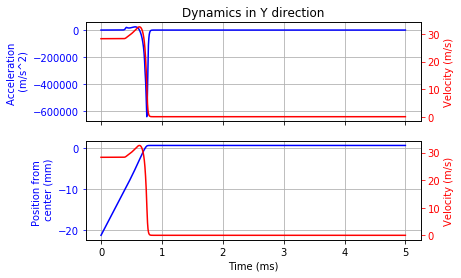

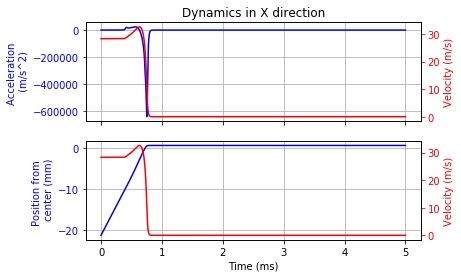

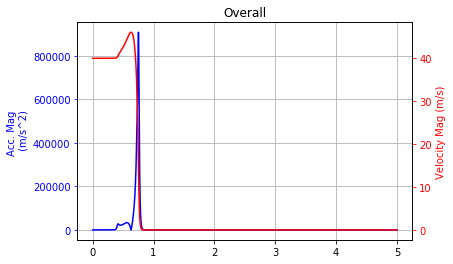

In [5]:
# Setting up the force equations for MOT in 2D
# The MOT beams are along the X and Y direction. The push beam direction is Z. 
# Atoms effuse out of the oven, along a line tilted 45 degrees from X and Y on X-Y plane.
N = 10000

# Defining saturation parameter ================================================================================
def Sat(power,r,x,y,z): # det[MHz], power[mW], r[cm], y[m], z[m]
    S = (2*4*power/(np.pi*(r)**2*Isat))*np.exp(-2*(x**2+y**2+z**2)/(r*10**-2)**2)
    return S
# Defining scattering force in all dimensions ==================================================================
# beta goes to 0 if Molasses
def AccX(det,power,r,x,y,z,vx,beta): # det[MHz], power[mW], r[cm], x[m], y[m], z[m], vx[m/s]
    S = Sat(power,r,x,y,z)
    FieldSplit = beta*abs(np.sqrt(x**2+y**2+z**2))
    forward = (hbar*k*gamma*10**6/(2*m))*(S/(1+S+(4*((2*np.pi*det*10**6+k*vx+FieldSplit)/(gamma*10**6))**2)))
    backward = (hbar*k*gamma*10**6/(2*m))*(S/(1+S+(4*((2*np.pi*det*10**6-k*vx+FieldSplit)/(gamma*10**6))**2)))
    return [forward, backward]
def AccY(det,power,r,x,y,z,vy,beta): # det[MHz], power[mW], r[cm], x[m], y[m], z[m], vy[m/s]
    S = Sat(power,r,x,y,z)
    FieldSplit = beta*abs(np.sqrt(x**2+y**2+z**2))
    forward = (hbar*k*gamma*10**6/(2*m))*(S/(1+S+(4*((2*np.pi*det*10**6+k*vy+FieldSplit)/(gamma*10**6))**2)))
    backward = (hbar*k*gamma*10**6/(2*m))*(S/(1+S+(4*((2*np.pi*det*10**6-k*vy+FieldSplit)/(gamma*10**6))**2)))
    return [forward, backward]
def AccZ(det,power,r,x,y,z,vz,beta): # det[MHz], power[mW], r[cm], x[m], y[m], z[m], vy[m/s]
    forward = 0
    backward = 0
    return [forward, backward]

# Solving ODE for atom dynamics in the presence of laser ===================================================
from scipy.integrate import odeint
# MOT
def dU_dtMOT(U, t):
    # Here U is a vector such that U[0] = x or position and U[1] = x' or velocity.
    # This function should return [x', x"]
    NetAccX = -AccX(Det_cool,Power_cool,Rmot,U[0],U[1],U[2],U[3],beta)[0]+AccX(Det_cool,Power_cool,Rmot,U[0],U[1],U[2],U[3],beta)[1]
    NetAccY = -AccY(Det_cool,Power_cool,Rmot,U[0],U[1],U[2],U[4],beta)[0]+AccY(Det_cool,Power_cool,Rmot,U[0],U[1],U[2],U[4],beta)[1]
    NetAccZ = -AccZ(Det_cool,Power_cool,Rmot,U[0],U[1],U[2],U[5],beta)[0]+AccZ(Det_cool,Power_cool,Rmot,U[0],U[1],U[2],U[5],beta)[1]
    return [U[3], U[4], U[5], NetAccX, NetAccY, NetAccZ]

# Test Case: Atom entering the MOT region at a distance 4 times 2D MOT radius with velocity v at 45 degrees to X-Y
x = -4*Rmot*10**-2/np.sqrt(2) #[m]
y = -4*Rmot*10**-2/np.sqrt(2);#[m]
z = 0;#[m]
vx = 40/np.sqrt(2) #[m/s]
vy = 40/np.sqrt(2);#[m/s]
vz = 0;#[m/s]
Uint = [x,y,z,vx,vy,vz]
t = np.linspace(0, 0.005, N)
Usoln = odeint(dU_dtMOT, Uint, t)
posX = Usoln[:,0]
posY = Usoln[:,1]
posZ = Usoln[:,2]
velX = Usoln[:,3]
velY = Usoln[:,4]
velZ = Usoln[:,5]

accX = np.zeros(N);
accY = np.zeros(N);
accZ = np.zeros(N);
sat = np.zeros(N);
for ii in range(0, N):
    accX[ii] = -AccX(Det_cool,Power_cool,Rmot,posX[ii],posY[ii],posZ[ii],velX[ii],beta)[0]+AccX(Det_cool,Power_cool,Rmot,posX[ii],posY[ii],posZ[ii],velX[ii],beta)[1]
    accY[ii] = -AccY(Det_cool,Power_cool,Rmot,posX[ii],posY[ii],posZ[ii],velY[ii],beta)[0]+AccY(Det_cool,Power_cool,Rmot,posX[ii],posY[ii],posZ[ii],velY[ii],beta)[1]
    accZ[ii] = -AccZ(Det_cool,Power_cool,Rmot,posX[ii],posY[ii],posZ[ii],velZ[ii],beta)[0]+AccZ(Det_cool,Power_cool,Rmot,posX[ii],posY[ii],posZ[ii],velZ[ii],beta)[1]

f1, (ax1,ax3) = plt.subplots(2, sharex=True)
ax1.plot(t*10**3, accY, 'b')
ax1.set_ylabel('Acceleration \n (m/s^2)', color='b')
ax1.tick_params('y', colors='b')
ax2 = ax1.twinx()
ax2.plot(t*10**3, velY, 'r')
ax2.set_ylabel('Velocity (m/s)', color='r')
ax2.tick_params('y', colors='r')
ax3.plot(t*10**3, posY*10**3, 'b')
ax3.set_ylabel('Position from \n center (mm)', color='b')
ax3.tick_params('y', colors='b')
ax4 = ax3.twinx()
ax4.plot(t*10**3, velY, 'r')
ax4.set_ylabel('Velocity (m/s)', color='r')
ax4.tick_params('y', colors='r')
ax3.set_xlabel('Time (ms)')
ax1.set_title('Dynamics in Y direction')
ax1.grid()
ax3.grid()

f2, (ax1,ax3) = plt.subplots(2, sharex=True)
ax1.plot(t*10**3, accX, 'b')
ax1.set_ylabel('Acceleration \n (m/s^2)', color='b')
ax1.tick_params('y', colors='b')
ax2 = ax1.twinx()
ax2.plot(t*10**3, velX, 'r')
ax2.set_ylabel('Velocity (m/s)', color='r')
ax2.tick_params('y', colors='r')
ax3.plot(t*10**3, posX*10**3, 'b')
ax3.set_ylabel('Position from \n center (mm)', color='b')
ax3.tick_params('y', colors='b')
ax4 = ax3.twinx()
ax4.plot(t*10**3, velX, 'r')
ax4.set_ylabel('Velocity (m/s)', color='r')
ax4.tick_params('y', colors='r')
ax3.set_xlabel('Time (ms)')
ax1.set_title('Dynamics in X direction')
ax1.grid()
ax3.grid()

f3, ax1 = plt.subplots()
ax1.plot(t*10**3, np.sqrt(accX**2+accY**2), 'b')
ax1.set_ylabel('Acc. Mag \n (m/s^2)', color='b')
ax1.tick_params('y', colors='b')
ax2 = ax1.twinx()
ax2.plot(t*10**3, np.sqrt(velX**2+velY**2), 'r')
ax2.set_ylabel('Velocity Mag (m/s)', color='r')
ax2.tick_params('y', colors='r')
ax2.set_xlabel('Time (ms)')
ax1.set_title('Overall')
ax1.grid()

del(x,y,z,vx,vy,vz,Uint,t,Usoln,posX,posY,posZ,velX,velY,velZ,accX,accY,accZ)


### Estimation of Capture Velocity

<Figure size 432x288 with 0 Axes>

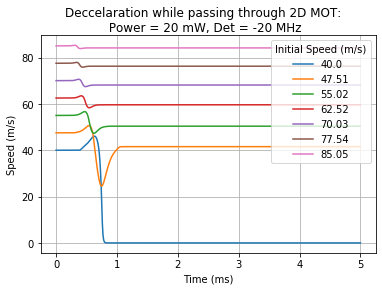

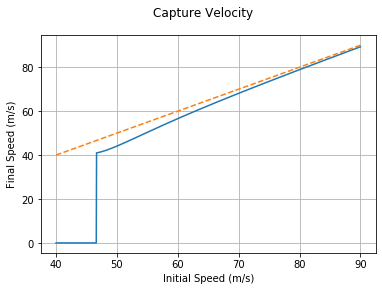

In [6]:
# Now solving for capture velocity
Nii = 1000
Njj = 1000
PlotEvery = 150
vyStart = 40;
vyEnd = 90;
vFinal = np.zeros(Nii)
speed = np.zeros(Njj)
legend = np.zeros((Nii-1)//PlotEvery+1)
InitialSpeed = np.linspace(vyStart, vyEnd, Nii)

x = -4*Rmot*10**-2/np.sqrt(2) #[m]
y = -4*Rmot*10**-2/np.sqrt(2);#[m]
z = 0;#[m]
vx = InitialSpeed/np.sqrt(2) #[m/s]
vy = InitialSpeed/np.sqrt(2) #[m/s]
vz = 0;#[m/s]
t = np.linspace(0, 0.005, Njj)


plt.figure(1)
f1, ax1 = plt.subplots()
aa = 0;
for ii in range(0, Nii):
    Uint = [x,y,z,vx[ii],vy[ii],vz]
    Usoln = odeint(dU_dtMOT, Uint, t)
    velX = Usoln[:,3]
    velY = Usoln[:,4]
    speed[:] = np.sqrt(Usoln[:,3]**2+Usoln[:,4]**2)
    if ii%(PlotEvery) == 0:
        ax1.plot(t*10**3,speed)
        legend[aa] = round(InitialSpeed[ii],2)
        aa = aa + 1
    vFinal[ii] = speed[Njj-1]
    del(velY,Uint,Usoln)
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Speed (m/s)', color='k')
ax1.tick_params('y', colors='k')
ax1.legend(legend,title = "Initial Speed (m/s)",loc='upper right');
f1.suptitle("Deccelaration while passing through 2D MOT:\n Power = {0} mW, Det = {1} MHz".format(round(Power_cool,0),round(Det_cool,0)))
ax1.grid()

plt.figure(2)
f2, ax1 = plt.subplots()
ax1.plot(InitialSpeed,vFinal,'-',InitialSpeed,InitialSpeed,'--')
f2.suptitle("Capture Velocity")
ax1.set_xlabel('Initial Speed (m/s)')
ax1.set_ylabel('Final Speed (m/s)', color='k')
ax1.tick_params('y', colors='k')
del(Nii, Njj, vyStart, vyEnd, vFinal, speed, InitialSpeed, x, y, z, vx, vy, vz, t)
ax1.grid()


#### Capture Velocity for different Cooling Powers and Detunings

<Figure size 432x288 with 0 Axes>

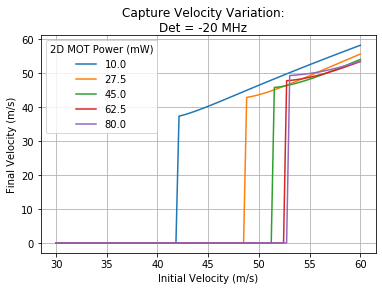

In [7]:
# Variation of capture velocity with cooling power
Nii = 100
Njj = 1000
Nkk = 5
vyStart = 30;
vyEnd = 60;
InitialSpeed = np.linspace(vyStart, vyEnd, Nii)


x = -4*Rmot*10**-2/np.sqrt(2) #[m]
y = -4*Rmot*10**-2/np.sqrt(2);#[m]
z = 0;#[m]
vx = InitialSpeed/np.sqrt(2) #[m/s]
vy = InitialSpeed/np.sqrt(2) #[m/s]
vz = 0;#[m/s]
t = np.linspace(0, 0.005, Njj)
Power = np.linspace(10,80,Nkk) # [mW]

plt.figure(1)
f1, ax1 = plt.subplots()
for kk in range(0, Nkk):
    vFinal = np.zeros(Nii)
    from scipy.integrate import odeint
    def dU_dtMOT(U, t):
        # Here U is a vector such that U[0] = x or position and U[1] = x' or velocity.
        # This function should return [x', x"]
        NetAccX = -AccX(Det_cool,Power[kk],Rmot,U[0],U[1],U[2],U[3],beta)[0]+AccX(Det_cool,Power[kk],Rmot,U[0],U[1],U[2],U[3],beta)[1]
        NetAccY = -AccY(Det_cool,Power[kk],Rmot,U[0],U[1],U[2],U[4],beta)[0]+AccY(Det_cool,Power[kk],Rmot,U[0],U[1],U[2],U[4],beta)[1]
        NetAccZ = -AccZ(Det_cool,Power[kk],Rmot,U[0],U[1],U[2],U[5],beta)[0]+AccZ(Det_cool,Power[kk],Rmot,U[0],U[1],U[2],U[5],beta)[1]
        return [U[3], U[4], U[5], NetAccX, NetAccY, NetAccZ]
    for ii in range(0, Nii):
        speed = np.zeros(Njj)
        Uint = [x,y,z,vx[ii],vy[ii],vz]
        Usoln = odeint(dU_dtMOT, Uint, t)
        velX = Usoln[:,3]
        velY = Usoln[:,4]
        speed[:] = np.sqrt(Usoln[:,3]**2+Usoln[:,4]**2)
        vFinal[ii] = speed[Njj-1]
        del(velX,velY,Uint,Usoln,speed)
    ax1.plot(InitialSpeed,vFinal,'-')
    del(vFinal)
ax1.set_xlabel('Initial Velocity (m/s)')
ax1.set_ylabel('Final Velocity (m/s)', color='k')
ax1.tick_params('y', colors='k') 
f1.suptitle("Capture Velocity Variation:\nDet = {0} MHz".format(round(Det_cool,0)))
ax1.legend(Power,title = "2D MOT Power (mW)");
ax1.grid()
del(Nii, Njj, Nkk, vyStart, vyEnd, InitialSpeed, x, y, z, vx, vy, vz, t, Power)


<Figure size 432x288 with 0 Axes>

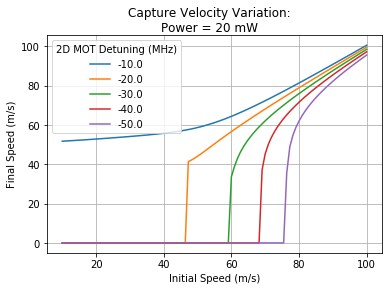

In [8]:
# Variation of capture velocity with cooling detuning
Nii = 100
Njj = 1000
Nkk = 5
vyStart = 10;
vyEnd = 100;
posFinal = np.zeros(Nii)
InitialSpeed = np.linspace(vyStart, vyEnd, Nii)


x = -4*Rmot*10**-2/np.sqrt(2) #[m]
y = -4*Rmot*10**-2/np.sqrt(2);#[m]
z = 0;#[m]
vx = InitialSpeed/np.sqrt(2) #[m/s]
vy = InitialSpeed/np.sqrt(2) #[m/s]
vz = 0;#[m/s]
t = np.linspace(0, 0.005, Njj)
Det = np.linspace(-10,-50,Nkk) # [MHz]

plt.figure(1)
f1, ax1 = plt.subplots()
for kk in range(0, Nkk):
    vFinal = np.zeros(Nii)
    from scipy.integrate import odeint
    def dU_dtMOT(U, t):
        # Here U is a vector such that U[0] = x or position and U[1] = x' or velocity.
        # This function should return [x', x"]
        NetAccX = -AccX(Det[kk],Power_cool,Rmot,U[0],U[1],U[2],U[3],beta)[0]+AccX(Det[kk],Power_cool,Rmot,U[0],U[1],U[2],U[3],beta)[1]
        NetAccY = -AccY(Det[kk],Power_cool,Rmot,U[0],U[1],U[2],U[4],beta)[0]+AccY(Det[kk],Power_cool,Rmot,U[0],U[1],U[2],U[4],beta)[1]
        NetAccZ = -AccZ(Det[kk],Power_cool,Rmot,U[0],U[1],U[2],U[5],beta)[0]+AccZ(Det[kk],Power_cool,Rmot,U[0],U[1],U[2],U[5],beta)[1]
        return [U[3], U[4], U[5], NetAccX, NetAccY, NetAccZ]
    for ii in range(0, Nii):
        speed = np.zeros(Njj)
        Uint = [x,y,z,vx[ii],vy[ii],vz]
        Usoln = odeint(dU_dtMOT, Uint, t)
        velX = Usoln[:,3]
        velY = Usoln[:,4]
        speed[:] = np.sqrt(Usoln[:,3]**2+Usoln[:,4]**2)
        vFinal[ii] = speed[Njj-1]
        del(velX,velY,Uint,Usoln,speed)
    ax1.plot(InitialSpeed,vFinal,'-')
    del(vFinal)
ax1.set_xlabel('Initial Speed (m/s)')
ax1.set_ylabel('Final Speed (m/s)', color='k')
ax1.tick_params('y', colors='k') 
f1.suptitle("Capture Velocity Variation:\nPower = {0} mW".format(round(Power_cool,0)))
ax1.legend(Det,title = "2D MOT Detuning (MHz)");
ax1.grid()
del(Nii, Njj, Nkk, vyStart, vyEnd, InitialSpeed, x, y, z, vx, vy, vz, t, Det)


As seen from the above analysis, to have decent capture velocities, we need relatively large detunings of the cooling beam. This is because the field gradient produced by the permanent magnets is very high. Also, as expected, higher cooling power helps increase the capture velocity. The effect is more dramatic as we drop down to detunings of -10 MHz. We should shoot for a detuning < -20MHz. Another important takeaway from the above analysis is that atoms captured in the 2D MOT are at the very low-velocity tail of the Maxwell Boltzmann distribution. The 2D MOT does not capture a majority of the atoms ejected out of the oven. As seen from the plots in the introduction, we only gain in atomic flux by increasing the temperature. $\textbf{The change in velocity distribution has no effect in the low-velocity tail we care about}$.

<a id="C2"></a>
### Slowing with just the repump beam
Conventionally, repumps are sent along with the cooling beams. While setting up the 2D MOT, we accidentally realized that the atom number increased by a factor of five if the repump propagated in the direction opposite to the atomic flux, indicating the possibility of a slowing action by the repump. To investigate this, I performed the following analysis. Consider a bare single repump beam (with no cooling slower beam). As shown in the 2D MOT schematic, the repump beam intersects the MOT center making an angle of 45 degrees with both 2D MOT cooling beams. The repump can slow down atoms only in the MOT region, beyond which there is no cooling light. As a result, the repump has an effective slowing action only in the region $y \subset [ -\sqrt{2}R_{2DMOT},-\sqrt{2}R_{2DMOT},]$. The simulations below deploy the scattering force in this region.

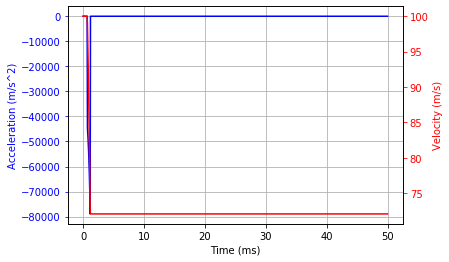

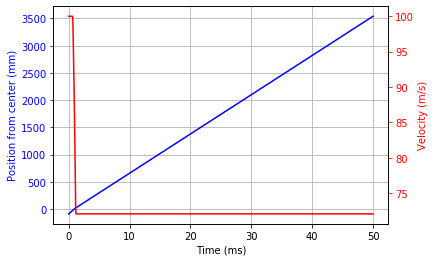

In [68]:
# Slowing with radiation pressure with just a repump beam
# 2D MOT is on X-Y plane with repump travelling along Y. The push beam is along Z.
N = 1000

# Defining saturation parameter
# The saturation parameter is defined by the repump beam radius in the X and Z directions.
# However in the Y direction, it is given by the MOT region where sufficient cooling light
# is available.
def Sat(power,r,x,y,z): # det[MHz], power[mW], r[cm], x[m]
    if (y>=-2*np.sqrt(2)*Rmot*10**-2 and y<=2*np.sqrt(2)*Rmot*10**-2):
        S = (2*power/(np.pi*(r)**2*Isat))*np.exp(-2*(x**2+z**2)/(r*10**-2)**2)
    else:
        S = 0
    return S

# Defining scattering force in 3D
# In the case of slower  traversing in Y direction, the force is only in the Y direction.
def AccX(det,power,r,x,y,z,vx): # det[MHz], power[mW], r[cm], x[m]
    forward = 0
    backward = 0
    return [forward, backward]
def AccY(det,power,r,x,y,z,vy): # det[MHz], power[mW], r[cm], x[m]
    S = Sat(power,r,x,y,z)
    forward = (hbar*k*gamma*10**6/(2*m))*(S/(1+S+(4*((2*np.pi*det*10**6+k*vy)/(gamma*10**6))**2)))
    backward = (hbar*k*gamma*10**6/(2*m))*(S/(1+S+(4*((2*np.pi*det*10**6-k*vy)/(gamma*10**6))**2)))
    return [forward, backward]
def AccZ(det,power,r,x,y,z,vz): # det[MHz], power[mW], r[cm], x[m]
    forward = 0
    backward = 0
    return [forward, backward]


# Solving ODE for atom dynamics in the presence of laser
from scipy.integrate import odeint
def dU_dt(U, t):
    # Here U is a vector such that U[0] = x or position and U[1] = x' or velocity.
    # This function should return [x', x"]
    NetAccX = -AccX(Det_repump,Power_repump,Rzs,U[0],U[1],U[2],U[3])[0]
    NetAccY = -AccY(Det_repump,Power_repump,Rzs,U[0],U[1],U[2],U[4])[0]
    NetAccZ = -AccZ(Det_repump,Power_repump,Rzs,U[0],U[1],U[2],U[5])[0]
    return [U[3], U[4], U[5], NetAccX, NetAccY, NetAccZ]

# Test Case: Atom effusing out of oven nozzle with v along positive Y direction.
x = 0 #[m]
y = -L;#[m]
z = 0;#[m]
vx = 0 #[m/s]
vy = 100;#[m/s]
vz = 0;#[m/s]
Uint = [x,y,z,vx,vy,vz]
t = np.linspace(0, 0.05, N)
Usoln = odeint(dU_dt, Uint, t)
posX = Usoln[:,0]
posY = Usoln[:,1]
posZ = Usoln[:,2]
velX = Usoln[:,3]
velY = Usoln[:,4]
velZ = Usoln[:,5]

accX = np.zeros(N);
accY = np.zeros(N);
accZ = np.zeros(N);
sat = np.zeros(N);
for ii in range(0, N):
    accX[ii] = -AccX(Det_repump,Power_repump, Rzs,posX[ii],posY[ii],posZ[ii],velX[ii])[0]
    accY[ii] = -AccY(Det_repump,Power_repump, Rzs,posX[ii],posY[ii],posZ[ii],velY[ii])[0]
    accZ[ii] = -AccZ(Det_repump,Power_repump, Rzs,posX[ii],posY[ii],posZ[ii],velZ[ii])[0]
    sat[ii] = Sat(Power_repump,Rzs,posX[ii],posY[ii],posZ[ii])

fig, ax1 = plt.subplots()
ax1.plot(t*10**3, accY, 'b')
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Acceleration (m/s^2)', color='b')
ax1.tick_params('y', colors='b')
ax2 = ax1.twinx()
ax2.plot(t*10**3, velY, 'r')
ax2.set_ylabel('Velocity (m/s)', color='r')
ax2.tick_params('y', colors='r')
ax1.grid()

fig, ax1 = plt.subplots()
ax1.plot(t*10**3, posY*10**3, 'b')
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Position from center (mm)', color='b')
ax1.tick_params('y', colors='b')
ax2 = ax1.twinx()
ax2.plot(t*10**3, velY, 'r')
ax2.set_ylabel('Velocity (m/s)', color='r')
ax2.tick_params('y', colors='r')
ax1.grid()

del(x,y,z,vx,vy,vz,Uint,t,Usoln,posX,posY,posZ,velX,velY,velZ,accX,accY,accZ)


<Figure size 432x288 with 0 Axes>

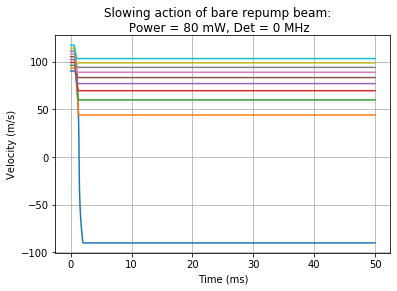

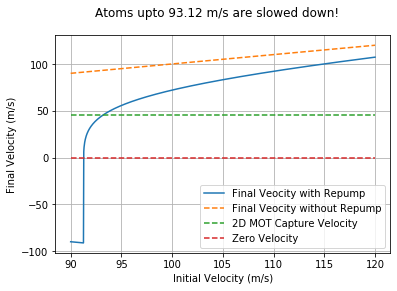

In [69]:
Nii = 1000
Njj = 1000
vyStart = 90;
vyEnd = 120;
vFinal = np.zeros(Nii)
vCap = 45; # Capture Velocity of the 2D MOT[m/s]

x = 0 #[m]
y = -L;#[m]
z = 0;#[m]
vx = 0 #[m/s]
vy = np.linspace(vyStart, vyEnd, Nii)
vz = 0;#[m/s]
t = np.linspace(0, 0.05, Njj)


plt.figure(1)
f1, ax1 = plt.subplots()
for ii in range(0, Nii):
    Uint = [x,y,z,vx,vy[ii],vz]
    Usoln = odeint(dU_dt, Uint, t)
    posY = Usoln[:,1]
    velY = Usoln[:,4]
    if ii%(100) == 0:
        ax1.plot(t*10**3,velY)
    vFinal[ii] = velY[Njj-1]
    del(posY,velY,Uint,Usoln)
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Velocity (m/s)', color='k')
ax1.tick_params('y', colors='k')
f1.suptitle("Slowing action of bare repump beam:\n Power = {0} mW, Det = {1} MHz".format(round(Power_repump,0),round(Det_repump,0)))
vSlowedStart = vy[find_nearest_index(vFinal,0)];
vSlowedEnd = vy[find_nearest_index(vFinal,vCap)]
ax1.grid()

plt.figure(2)
f2, ax1 = plt.subplots()
ax1.plot(vy,vFinal,'-',vy,vy,'--',vy,vCap*np.ones(Nii),'--',vy,0*np.ones(Nii),'--')
ax1.set_xlabel('Initial Velocity (m/s)')
ax1.set_ylabel('Final Velocity (m/s)', color='k')
ax1.tick_params('y', colors='k')
ax1.legend(['Final Veocity with Repump','Final Veocity without Repump','2D MOT Capture Velocity','Zero Velocity'])
f2.suptitle("Atoms upto {0} m/s are slowed down!".format(round(vSlowedEnd,2)))
ax1.grid()

del(Nii, Njj, vyStart, vyEnd, vFinal, x, y, z, vx, vy, vz, t)



So we see that a big chunk of high velocity atoms are slowed down by this repump beam travelling against the atom flux. Plainly looking at this analysis, one gets the impression that some of the slower atoms are slowed to a negative velocity and ultimately pushed back into the oven. This would mean that even though we trap more of the higher velocity atoms, we loose a lot of slow atoms. However our simple analysis doesn't take into account the forces of the cooling beams. Atoms that reach the 2D MOT with a velocity less than the capture velocity are trapped due to the overdamped harmonic potential force of the 2D MOT. Since, in this case all the cooling happens in the 2D MOT region, the moment atoms are cooled to below capture velocity, they get trapped. As a result there is only a gain in atom number.
To understand the effect of this gain, we consider the maxwell boltzmann distribution and assume a capture velocity of 45 m/s. As we see below there is a significant increase in the atomic flux due to the atoms slowed by the repump. 

#### Increase in Atom Number due to Counter Propagating Repump

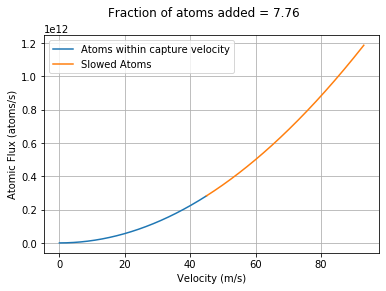

In [70]:
# Maxwell Boltzmann
N = 1000;

T = Toven+273;
P = 133.322*10**(2.881+4.704-5377/T); # Vapor Pressure [Pa]
n = P/(kB*T); # Number density of atoms [atoms/m^3]
v = np.sqrt(8*kB*T/(np.pi*m)); # Mean velocity of atoms [m/s]
Flux = (8*(Dnozzle/2)/(3*Lnozzle))*n*v*Anozzle; # Atomic Flux [atoms/s]
del(v)
v1 = np.linspace(0,vCap,N); # Velocities [m/s]
f1 = Flux*(m/(2*np.pi*kB*T))**(3/2)*4*np.pi*v1**2*np.exp(-m*v1**2/(2*kB*T));
f1_tot = np.trapz(f1,v1)
v2 = np.linspace(vCap,vSlowedEnd,N); # Velocities [m/s]
f2 = Flux*(m/(2*np.pi*kB*T))**(3/2)*4*np.pi*v2**2*np.exp(-m*v2**2/(2*kB*T));
f2_tot = np.trapz(f2,v2)


plt.figure(1)
plt.plot(v1,f1,v2,f2);
plt.title("");
plt.ylabel("Atomic Flux (atoms/s)");
plt.xlabel("Velocity (m/s)");
plt.legend(["Atoms within capture velocity", "Slowed Atoms"])
plt.suptitle("Fraction of atoms added = {0} ".format(round(f2_tot/f1_tot,2)))
plt.grid()


<a id="C3"></a>
### Slowing action of Slower
We also observe a big increase in atom number with a slower beam along with the repump. This atom number increases further if we add a red-detuned repump along with the slower and on-resonance repump. In the following two code blocks I try to understand the slowing action of the slower beam. Finally with the maxwell boltzmann plot we clearly see why there is a huge increase in atom number with the slower beam.

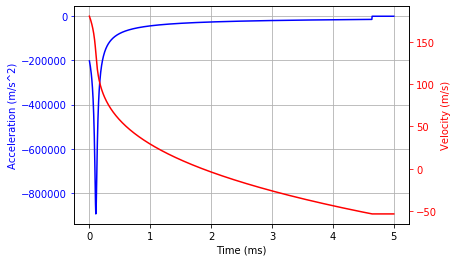

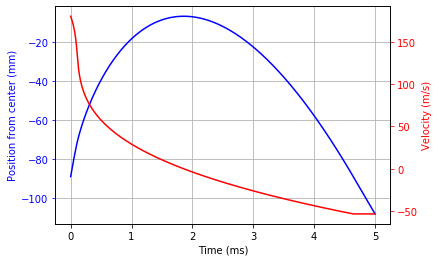

In [71]:
# Slowing with a slower beam with appropriate repumping
# 2D MOT is on X-Y plane with repump travelling along Y. The push beam is along Z.
N = 1000

# Defining saturation parameter
# The saturation parameter is defined by the slower beam radius in the X and Z directions.
# However in the Y direction, it doesn't change. Here however we consider a step function
# for the region between the nozzle end and the end of the 2D MOT region.
def Sat(power,r,x,y,z): # det[MHz], power[mW], r[cm], x[m]
    if (y>=-L and y<=np.sqrt(2)*Rmot*10**-2):
        S = (2*power/(np.pi*(r)**2*Isat))*np.exp(-2*(x**2+z**2)/(r*10**-2)**2)
    else:
        S = 0
    return S

# Defining scattering force in 3D
# In the case of slower  traversing in Y direction, the force is only in the Y direction.
def AccX(det,power,r,x,y,z,vx): # det[MHz], power[mW], r[cm], x[m]
    forward = 0
    backward = 0
    return [forward, backward]
def AccY(det,power,r,x,y,z,vy): # det[MHz], power[mW], r[cm], x[m]
    S = Sat(power,r,x,y,z)
    forward = (hbar*k*gamma*10**6/(2*m))*(S/(1+S+(4*((2*np.pi*det*10**6+k*vy)/(gamma*10**6))**2)))
    backward = (hbar*k*gamma*10**6/(2*m))*(S/(1+S+(4*((2*np.pi*det*10**6-k*vy)/(gamma*10**6))**2)))
    return [forward, backward]
def AccZ(det,power,r,x,y,z,vz): # det[MHz], power[mW], r[cm], x[m]
    forward = 0
    backward = 0
    return [forward, backward]


# Solving ODE for atom dynamics in the presence of laser
from scipy.integrate import odeint
def dU_dt(U, t):
    # Here U is a vector such that U[0] = x or position and U[1] = x' or velocity.
    # This function should return [x', x"]
    NetAccX = -AccX(Det_slow,Power_slow,Rzs,U[0],U[1],U[2],U[3])[0]
    NetAccY = -AccY(Det_slow,Power_slow,Rzs,U[0],U[1],U[2],U[4])[0]
    NetAccZ = -AccZ(Det_slow,Power_slow,Rzs,U[0],U[1],U[2],U[5])[0]
    return [U[3], U[4], U[5], NetAccX, NetAccY, NetAccZ]

# Test Case: Atom entering the molasses regoin at x =equal to a distance 4 times 3D MOT radius with velocity v = 100 m/s
x = 0 #[m]
y = -L;#[m]
z = 0;#[m]
vx = 0 #[m/s]
vy = 180;#[m/s]
vz = 0;#[m/s]
Uint = [x,y,z,vx,vy,vz]
t = np.linspace(0, 0.005, N)
Usoln = odeint(dU_dt,Uint, t)
posX = Usoln[:,0]
posY = Usoln[:,1]
posZ = Usoln[:,2]
velX = Usoln[:,3]
velY = Usoln[:,4]
velZ = Usoln[:,5]

accX = np.zeros(N);
accY = np.zeros(N);
accZ = np.zeros(N);
sat = np.zeros(N);
for ii in range(0, N):
    accX[ii] = -AccX(Det_slow,Power_slow,Rzs,posX[ii],posY[ii],posZ[ii],velX[ii])[0]
    accY[ii] = -AccY(Det_slow,Power_slow,Rzs,posX[ii],posY[ii],posZ[ii],velY[ii])[0]
    accZ[ii] = -AccZ(Det_slow,Power_slow,Rzs,posX[ii],posY[ii],posZ[ii],velZ[ii])[0]
    sat[ii] = Sat(Power_slow,Rzs,posX[ii],posY[ii],posZ[ii])

fig, ax1 = plt.subplots()
ax1.plot(t*10**3, accY, 'b')
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Acceleration (m/s^2)', color='b')
ax1.tick_params('y', colors='b')
ax2 = ax1.twinx()
ax2.plot(t*10**3, velY, 'r')
ax2.set_ylabel('Velocity (m/s)', color='r')
ax2.tick_params('y', colors='r')
ax1.grid()

fig, ax1 = plt.subplots()
ax1.plot(t*10**3, posY*10**3, 'b')
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Position from center (mm)', color='b')
ax1.tick_params('y', colors='b')
ax2 = ax1.twinx()
ax2.plot(t*10**3, velY, 'r')
ax2.set_ylabel('Velocity (m/s)', color='r')
ax2.tick_params('y', colors='r')
ax1.grid()

del(x,y,z,vx,vy,vz,Uint,t,Usoln,posX,posY,posZ,velX,velY,velZ,accX,accY,accZ)

<Figure size 432x288 with 0 Axes>

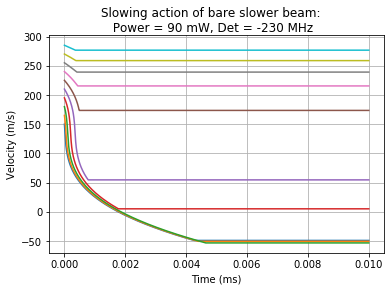

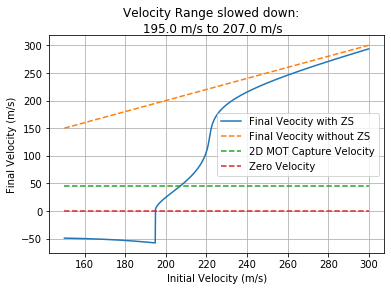

In [73]:
Nii = 1000
Njj = 1000
vyStart = 150;
vyEnd = 300;
vFinal = np.zeros(Nii)
posFinal = np.zeros(Nii)
vCap = 45;

x = 0 #[m]
y = -L;#[m]
z = 0;#[m]
vx = 0 #[m/s]
vy = np.linspace(vyStart, vyEnd, Nii)
vz = 0;#[m/s]
t = np.linspace(0, 0.01, Njj)


plt.figure(1)
f1, ax1 = plt.subplots()
for ii in range(0, Nii):
    Uint = [x,y,z,vx,vy[ii],vz]
    Usoln = odeint(dU_dt, Uint, t)
    posY = Usoln[:,1]
    velY = Usoln[:,4]
    if ii%(100) == 0:
        ax1.plot(t,velY)
    vFinal[ii] = velY[Njj-1]
    del(posY,velY,Uint,Usoln)
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Velocity (m/s)', color='k')
ax1.tick_params('y', colors='k')
f1.suptitle("Slowing action of bare slower beam:\n Power = {0} mW, Det = {1} MHz".format(round(Power_slow,0),round(Det_slow,0)))
vSlowedStart = vy[find_nearest_index(vFinal,0)];
vSlowedEnd = vy[find_nearest_index(vFinal,vCap)]
ax1.grid()

plt.figure(2)
f2, ax1 = plt.subplots()
ax1.plot(vy,vFinal,'-',vy,vy,'--',vy,vCap*np.ones(Nii),'--',vy,0*np.ones(Nii),'--')
ax1.set_xlabel('Initial Velocity (m/s)')
ax1.set_ylabel('Final Velocity (m/s)', color='k')
ax1.tick_params('y', colors='k')
ax1.legend(['Final Veocity with ZS','Final Veocity without ZS','2D MOT Capture Velocity','Zero Velocity'])
ax1.grid()
f2.suptitle("Velocity Range slowed down:\n {0} m/s to {1} m/s".format(round(vSlowedStart,0),round(vSlowedEnd,0)))

del(Nii, Njj, vyStart, vyEnd, vFinal, x, y, z, vx, vy, vz, t)


#### Increase in Atom Number due to Slower

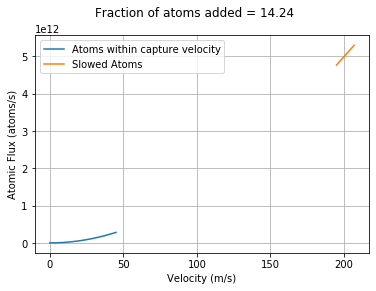

In [74]:
# Maxwell Boltzmann
N = 1000;

T = 200+273;
P = 133.322*10**(2.881+4.704-5377/T); # Vapor Pressure [Pa]
n = P/(kB*T); # Number density of atoms [atoms/m^3]
v = np.sqrt(8*kB*T/(np.pi*m)); # Mean velocity of atoms [m/s]
Flux = (8*(Dnozzle/2)/(3*Lnozzle))*n*v*Anozzle; # Atomic Flux [atoms/s]
del(v)
v1 = np.linspace(0,vCap,N); # Velocities [m/s]
f1 = Flux*(m/(2*np.pi*kB*T))**(3/2)*4*np.pi*v1**2*np.exp(-m*v1**2/(2*kB*T));
f1_tot = np.trapz(f1,v1)
v2 = np.linspace(vSlowedStart,vSlowedEnd,N); # Velocities [m/s]
f2 = Flux*(m/(2*np.pi*kB*T))**(3/2)*4*np.pi*v2**2*np.exp(-m*v2**2/(2*kB*T));
f2_tot = np.trapz(f2,v2)


plt.figure(1)
plt.plot(v1,f1,v2,f2);
plt.title("");
plt.ylabel("Atomic Flux (atoms/s)");
plt.xlabel("Velocity (m/s)");
plt.legend(["Atoms within capture velocity", "Slowed Atoms"])
plt.suptitle("Fraction of atoms added = {0} ".format(round(f2_tot/f1_tot,2)))
plt.grid()



<Figure size 432x288 with 0 Axes>

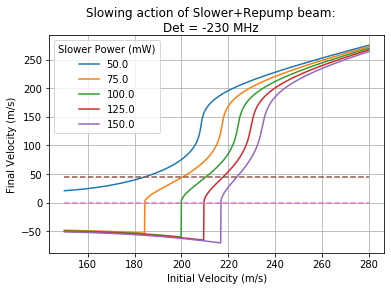

In [75]:
# Variation of slower power

Nii = 1000
Njj = 1000
Nkk = 5
vyStart = 150;
vyEnd = 280;
posFinal = np.zeros(Nii)

x = 0 #[m]
y = -L;#[m]
z = 0;#[m]
vx = 0 #[m/s]
vy = np.linspace(vyStart, vyEnd, Nii)
vz = 0;#[m/s]
t = np.linspace(0, 0.05, Njj)
Power = np.linspace(50,150,Nkk)

plt.figure(1)
f1, ax1 = plt.subplots()
for kk in range(0, Nkk):
    vFinal = np.zeros(Nii)
    from scipy.integrate import odeint
    def dU_dt(U, t):
        # Here U is a vector such that U[0] = x or position and U[1] = x' or velocity.
        # This function should return [x', x"]
        NetAccX = -AccX(Det_slow,Power[kk],Rzs,U[0],U[1],U[2],U[3])[0]
        NetAccY = -AccY(Det_slow,Power[kk],Rzs,U[0],U[1],U[2],U[4])[0]
        NetAccZ = -AccZ(Det_slow,Power[kk],Rzs,U[0],U[1],U[2],U[5])[0]
        return [U[3], U[4], U[5], NetAccX, NetAccY, NetAccZ]
    for ii in range(0, Nii):
        Uint = [x,y,z,vx,vy[ii],vz]
        Usoln = odeint(dU_dt, Uint, t)
        posY = Usoln[:,1]
        velY = Usoln[:,4]
        vFinal[ii] = velY[Njj-1]
        del(posY,velY,Uint,Usoln)
    ax1.plot(vy,vFinal,'-')
    del(vFinal)
ax1.plot(vy,vCap*np.ones(Nii),'--',vy,0*np.ones(Nii),'--')
ax1.set_xlabel('Initial Velocity (m/s)')
ax1.set_ylabel('Final Velocity (m/s)', color='k')
ax1.tick_params('y', colors='k') 
f1.suptitle("Slowing action of Slower+Repump beam:\nDet = {0} MHz".format(round(Det_slow,0)))
ax1.legend(Power,title = "Slower Power (mW)");
ax1.grid()
del(Nii, Njj, Nkk, vyStart, vyEnd, x, y, z, vx, vy, vz, t, Power)




<Figure size 432x288 with 0 Axes>

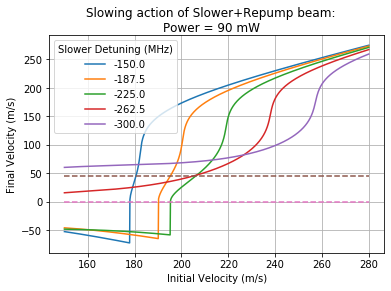

In [76]:
# Variation with Detuning

Nii = 1000
Njj = 1000
Nkk = 5
vyStart = 150;
vyEnd = 280;
posFinal = np.zeros(Nii)

x = 0 #[m]
y = -L;#[m]
z = 0;#[m]
vx = 0 #[m/s]
vy = np.linspace(vyStart, vyEnd, Nii)
vz = 0;#[m/s]
t = np.linspace(0, 0.05, Njj)
Det = np.linspace(-150,-300,Nkk)

plt.figure(1)
f1, ax1 = plt.subplots()
for kk in range(0, Nkk):
    vFinal = np.zeros(Nii)
    from scipy.integrate import odeint
    def dU_dt(U, t):
        # Here U is a vector such that U[0] = x or position and U[1] = x' or velocity.
        # This function should return [x', x"]
        NetAccX = -AccX(Det[kk],Power_slow,Rzs,U[0],U[1],U[2],U[3])[0]
        NetAccY = -AccY(Det[kk],Power_slow,Rzs,U[0],U[1],U[2],U[4])[0]
        NetAccZ = -AccZ(Det[kk],Power_slow,Rzs,U[0],U[1],U[2],U[5])[0]
        return [U[3], U[4], U[5], NetAccX, NetAccY, NetAccZ]
    for ii in range(0, Nii):
        Uint = [x,y,z,vx,vy[ii],vz]
        Usoln = odeint(dU_dt, Uint, t)
        posY = Usoln[:,1]
        velY = Usoln[:,4]
        vFinal[ii] = velY[Njj-1]
        del(posY,velY,Uint,Usoln)
    ax1.plot(vy,vFinal,'-')
    del(vFinal)
ax1.plot(vy,vCap*np.ones(Nii),'--',vy,0*np.ones(Nii),'--')
ax1.set_xlabel('Initial Velocity (m/s)')
ax1.set_ylabel('Final Velocity (m/s)', color='k')
ax1.tick_params('y', colors='k') 
f1.suptitle("Slowing action of Slower+Repump beam:\nPower = {0} mW".format(round(Power_slow,0)))
ax1.legend(Det,title = "Slower Detuning (MHz)");
ax1.grid()
del(Nii, Njj, Nkk, vyStart, vyEnd, x, y, z, vx, vy, vz, t, Det)

#### Experimental Observation: Slower Detuning and Power

Experimentally we were capable of scaning our AOM frequency by only 20 MHz. So we looked at the atom number variation with slower power at three different frequencies. The atom number starts saturating at around 60 mW in all cases. However 230 MHz consistently yields a higher atom number at higher power. This is qualitatively consistent with the simulations above. 
With the slower detuned more and more to the red, atoms with larger velocities are slowed down and the smaller velocity atoms are not pushed back into the oven. This is very evident comparing the green and red plots above. In the red curve, the slower is slowing down a higher velocity class. In the green, the slower is not only acting on slower atoms but is indeed pushing some atoms back into the oven. Overall the number of atoms with capturable velocities is more for red than green. This is what we see as we move from a detuning of -220 MHz to -230 MHz. However as we move to -240 MHz, the atom number drops indicating that the slowed atoms are not slowed enough to be in the capture range of the 2D MOT. The purple simulation curve above depicts this phenomenon. 
Also, as the power of the slower beam increases, the slowed velocity class shifts to higher velocities. For non-dramatic changes in power, this is experimentally manifested in the form of increase in atom number. We see this behavior for all three frequencies. The velocity class that is being slowed down

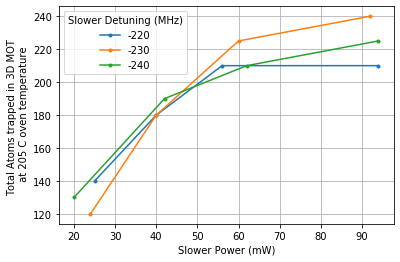

In [77]:
# Experimental Observation

Det_exp = [-190-30, -190-40, -190-50]
Power1 = [25,40,56,94]
AN1 = [140,180,210,210]
Power2 = [24,40,60,92]
AN2 = [120,180,225,240]
Power3 = [20,42,62,94]
AN3 = [130,190,210,225]

plt.figure(1)
plt.plot(Power1,AN1,'.-',Power2,AN2,'.-',Power3,AN3,'.-');
plt.title("");
plt.ylabel("Total Atoms trapped in 3D MOT \n at 205 C oven temperature");
plt.xlabel("Slower Power (mW)");
plt.legend(Det_exp,title = "Slower Detuning (MHz)");
plt.grid()


<Figure size 432x288 with 0 Axes>

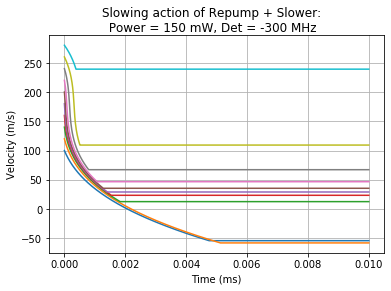

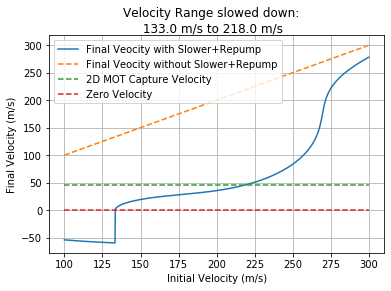

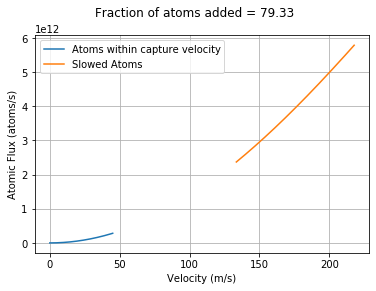

In [78]:
# Slowing with a slower beam with appropriate repumping
# 2D MOT is on X-Y plane with repump travelling along Y. The push beam is along Z.
# Here we enter test values of slower power and detuning
N = 1000
Power_test = 150 #[mW]
Det_test = -300 #[MHz]

# Defining saturation parameter
def Sat(power,r,x,y,z): # det[MHz], power[mW], r[cm], x[m]
    if (y>=-L and y<=np.sqrt(2)*Rmot*10**-2):
        S = (2*power/(np.pi*(r)**2*Isat))*np.exp(-2*(x**2+z**2)/(r*10**-2)**2)
    else:
        S = 0
    return S

# Defining scattering force in 3D
# In the case of slower  traversing in Y direction, the force is only in the Y direction.
def AccX(det,power,r,x,y,z,vx): # det[MHz], power[mW], r[cm], x[m]
    forward = 0
    backward = 0
    return [forward, backward]
def AccY(det,power,r,x,y,z,vy): # det[MHz], power[mW], r[cm], x[m]
    S = Sat(power,r,x,y,z)
    forward = (hbar*k*gamma*10**6/(2*m))*(S/(1+S+(4*((2*np.pi*det*10**6+k*vy)/(gamma*10**6))**2)))
    backward = (hbar*k*gamma*10**6/(2*m))*(S/(1+S+(4*((2*np.pi*det*10**6-k*vy)/(gamma*10**6))**2)))
    return [forward, backward]
def AccZ(det,power,r,x,y,z,vz): # det[MHz], power[mW], r[cm], x[m]
    forward = 0
    backward = 0
    return [forward, backward]


# Solving ODE for atom dynamics in the presence of laser
from scipy.integrate import odeint
def dU_dt(U, t):
    # Here U is a vector such that U[0] = x or position and U[1] = x' or velocity.
    # This function should return [x', x"]
    NetAccX = -AccX(Det_test,Power_test,Rzs,U[0],U[1],U[2],U[3])[0]
    NetAccY = -AccY(Det_test,Power_test,Rzs,U[0],U[1],U[2],U[4])[0]
    NetAccZ = -AccZ(Det_test,Power_test,Rzs,U[0],U[1],U[2],U[5])[0]
    return [U[3], U[4], U[5], NetAccX, NetAccY, NetAccZ]

Nii = 1000
Njj = 1000
vyStart = 100;
vyEnd = 300;
vFinal = np.zeros(Nii)
posFinal = np.zeros(Nii)

x = 0 #[m]
y = -L;#[m]
z = 0;#[m]
vx = 0 #[m/s]
vy = np.linspace(vyStart, vyEnd, Nii)
vz = 0;#[m/s]
t = np.linspace(0, 0.01, Njj)


plt.figure(1)
f1, ax1 = plt.subplots()
for ii in range(0, Nii):
    Uint = [x,y,z,vx,vy[ii],vz]
    Usoln = odeint(dU_dt, Uint, t)
    posY = Usoln[:,1]
    velY = Usoln[:,4]
    if ii%(100) == 0:
        ax1.plot(t,velY)
    vFinal[ii] = velY[Njj-1]
    del(posY,velY,Uint,Usoln)
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Velocity (m/s)', color='k')
ax1.tick_params('y', colors='k')
ax1.grid()
f1.suptitle("Slowing action of Repump + Slower:\n Power = {0} mW, Det = {1} MHz".format(round(Power_test,0),round(Det_test,0)))

vSlowedStart = vy[find_nearest_index(vFinal,0)];
vSlowedEnd = vy[find_nearest_index(vFinal,vCap)]
plt.figure(2)
f2, ax1 = plt.subplots()
ax1.plot(vy,vFinal,'-',vy,vy,'--',vy,vCap*np.ones(Nii),'--',vy,0*np.ones(Nii),'--')
ax1.set_xlabel('Initial Velocity (m/s)')
ax1.set_ylabel('Final Velocity (m/s)', color='k')
ax1.tick_params('y', colors='k')
ax1.legend(['Final Veocity with Slower+Repump','Final Veocity without Slower+Repump','2D MOT Capture Velocity','Zero Velocity'])
f2.suptitle("Velocity Range slowed down:\n {0} m/s to {1} m/s".format(round(vSlowedStart,0),round(vSlowedEnd,0)))
ax1.grid()

# Maxwell Boltzmann
N = 1000;

T = 200+273;
P = 133.322*10**(2.881+4.704-5377/T); # Vapor Pressure [Pa]
n = P/(kB*T); # Number density of atoms [atoms/m^3]
v = np.sqrt(8*kB*T/(np.pi*m)); # Mean velocity of atoms [m/s]
Flux = (8*(Dnozzle/2)/(3*Lnozzle))*n*v*Anozzle; # Atomic Flux [atoms/s]
del(v)
v1 = np.linspace(0,vCap,N); # Velocities [m/s]
f1 = Flux*(m/(2*np.pi*kB*T))**(3/2)*4*np.pi*v1**2*np.exp(-m*v1**2/(2*kB*T));
f1_tot = np.trapz(f1,v1)
v2 = np.linspace(vSlowedStart,vSlowedEnd,N); # Velocities [m/s]
f2 = Flux*(m/(2*np.pi*kB*T))**(3/2)*4*np.pi*v2**2*np.exp(-m*v2**2/(2*kB*T));
f2_tot = np.trapz(f2,v2)

plt.figure(3)
f3,ax1 = plt.subplots()
ax1.plot(v1,f1,v2,f2);
ax1.set_ylabel("Atomic Flux (atoms/s)");
ax1.set_xlabel("Velocity (m/s)");
ax1.legend(["Atoms within capture velocity", "Slowed Atoms"])
f3.suptitle("Fraction of atoms added = {0} ".format(round(f2_tot/f1_tot,2)))
ax1.grid()

del(Nii, Njj, vyStart, vyEnd, vFinal, x, y, z, vx, vy, vz, t)
del(Det_test,Power_test)

<a id="C4"></a>
### Push Beam Action
Once the atoms are slowed and trapped in the plane of 2D MOT, they are pushed towards the 3D MOT using a push beam. This is a very intense beam that pushes atoms straight into the 3D MOT through the differential pumping tube. Below we analyze how the push beam affects atoms moving with different velocities in the Z direction.

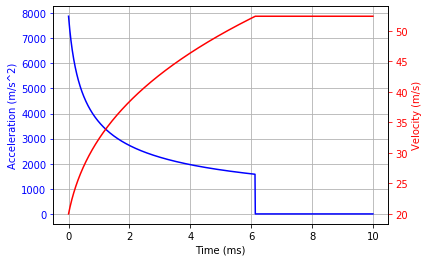

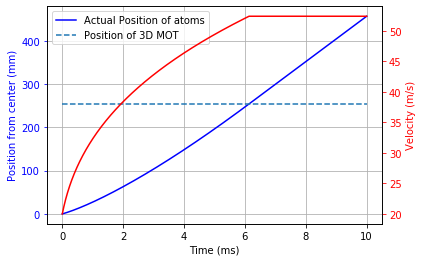

In [79]:
# Slowing with a slower beam with appropriate repumping
# 2D MOT is on X-Y plane with repump travelling along Y. The push beam is along Z.
N = 1000

# Defining saturation parameter
# The saturation parameter is defined by the slower beam radius in the X and Z directions.
# However in the Y direction, it doesn't change. Here however we consider a step function
# for the region between the nozzle end and the end of the 2D MOT region.
def Sat(power,r,x,y,z): # det[MHz], power[mW], r[cm], x[m]
    if (z<L_m2m):
        S = (2*power/(np.pi*(r)**2*Isat))*np.exp(-2*(x**2+y**2)/(r*10**-2)**2)
    else:
        S = 0
    return S

# Defining scattering force in 3D
# In the case of slower  traversing in Y direction, the force is only in the Y direction.
def AccX(det,power,r,x,y,z,vx): # det[MHz], power[mW], r[cm], x[m]
    forward = 0
    backward = 0
    return [forward, backward]
def AccY(det,power,r,x,y,z,vy): # det[MHz], power[mW], r[cm], x[m]
    forward = 0
    backward = 0
    return [forward, backward]
def AccZ(det,power,r,x,y,z,vz): # det[MHz], power[mW], r[cm], x[m]
    S = Sat(power,r,x,y,z)
    forward = (hbar*k*gamma*10**6/(2*m))*(S/(1+S+(4*((2*np.pi*det*10**6+k*vz)/(gamma*10**6))**2)))
    backward = (hbar*k*gamma*10**6/(2*m))*(S/(1+S+(4*((2*np.pi*det*10**6-k*vz)/(gamma*10**6))**2)))
    return [forward, backward]

# Solving ODE for atom dynamics in the presence of laser
from scipy.integrate import odeint
def dU_dt(U, t):
    # Here U is a vector such that U[0] = x or position and U[1] = x' or velocity.
    # This function should return [x', x"]
    NetAccX = AccX(Det_push,Power_push,Rpush,U[0],U[1],U[2],U[3])[1]
    NetAccY = AccY(Det_push,Power_push,Rpush,U[0],U[1],U[2],U[4])[1]
    NetAccZ = AccZ(Det_push,Power_push,Rpush,U[0],U[1],U[2],U[5])[1]
    return [U[3], U[4], U[5], NetAccX, NetAccY, NetAccZ]

# Test Case: 
x = 0 #[m]
y = 0;#[m]
z = 0;#[m]
vx = 0 #[m/s]
vy = 0;#[m/s]
vz = 20;#[m/s]
Uint = [x,y,z,vx,vy,vz]
t = np.linspace(0, 0.01, N)
Usoln = odeint(dU_dt,Uint, t)
posX = Usoln[:,0]
posY = Usoln[:,1]
posZ = Usoln[:,2]
velX = Usoln[:,3]
velY = Usoln[:,4]
velZ = Usoln[:,5]

accX = np.zeros(N);
accY = np.zeros(N);
accZ = np.zeros(N);
sat = np.zeros(N);
for ii in range(0, N):
    accX[ii] = AccX(Det_push,Power_push,Rpush,posX[ii],posY[ii],posZ[ii],velX[ii])[0]
    accY[ii] = AccY(Det_push,Power_push,Rpush,posX[ii],posY[ii],posZ[ii],velY[ii])[0]
    accZ[ii] = AccZ(Det_push,Power_push,Rpush,posX[ii],posY[ii],posZ[ii],velZ[ii])[0]
    sat[ii] = Sat(Power_push,Rpush,posX[ii],posY[ii],posZ[ii])

fig, ax1 = plt.subplots()
ax1.plot(t*10**3, accZ, 'b')
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Acceleration (m/s^2)', color='b')
ax1.tick_params('y', colors='b')
ax2 = ax1.twinx()
ax2.plot(t*10**3, velZ, 'r')
ax2.set_ylabel('Velocity (m/s)', color='r')
ax2.tick_params('y', colors='r')
ax1.grid()

fig, ax1 = plt.subplots()
ax1.plot(t*10**3, posZ*10**3, 'b',t*10**3, np.ones(N)*L_m2m*10**3,'--')
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Position from center (mm)', color='b')
ax1.tick_params('y', colors='b')
ax1.legend(['Actual Position of atoms','Position of 3D MOT'])
ax2 = ax1.twinx()
ax2.plot(t*10**3, velZ, 'r')
ax2.set_ylabel('Velocity (m/s)', color='r')
ax2.tick_params('y', colors='r')
ax1.grid()

del(x,y,z,vx,vy,vz,Uint,t,Usoln,posX,posY,posZ,velX,velY,velZ,accX,accY,accZ)

<Figure size 432x288 with 0 Axes>

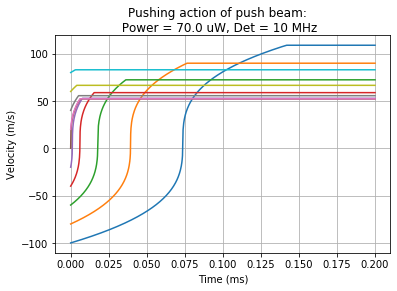

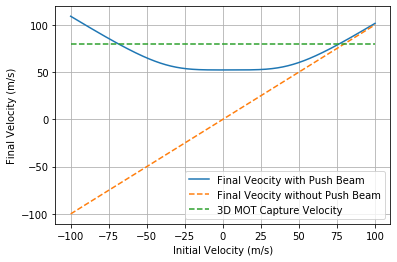

In [80]:
Nii = 1000
Njj = 1000
vzStart = -100;
vzEnd = 100;
vFinal = np.zeros(Nii)
posFinal = np.zeros(Nii)
vCap = 80;

x = 0 #[m]
y = 0;#[m]
z = 0;#[m]
vx = 0 #[m/s]
vy = 0;#[m/s]
vz = np.linspace(vzStart, vzEnd, Nii)
t = np.linspace(0, 0.2, Njj)


plt.figure(1)
f1, ax1 = plt.subplots()
for ii in range(0, Nii):
    Uint = [x,y,z,vx,vy,vz[ii]]
    Usoln = odeint(dU_dt, Uint, t)
    posZ = Usoln[:,2]
    velZ = Usoln[:,5]
    if ii%(100) == 0:
        ax1.plot(t,velZ)
    vFinal[ii] = velZ[Njj-1]
    del(posZ,velZ,Uint,Usoln)
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Velocity (m/s)', color='k')
ax1.tick_params('y', colors='k')
ax1.grid()
f1.suptitle("Pushing action of push beam:\n Power = {0} uW, Det = {1} MHz".format(round(10**3*Power_push,0),round(Det_push,0)))

plt.figure(2)
f2, ax1 = plt.subplots()
ax1.plot(vz,vFinal,'-',vz,vz,'--',vz,vCap*np.ones(Nii),'--')
ax1.set_xlabel('Initial Velocity (m/s)')
ax1.set_ylabel('Final Velocity (m/s)', color='k')
ax1.tick_params('y', colors='k')
ax1.legend(['Final Veocity with Push Beam','Final Veocity without Push Beam','3D MOT Capture Velocity'])
ax1.grid()
#f2.suptitle("Velocity Range slowed down:\n {0} m/s to {1} m/s".format(round(vSlowedStart,0),round(vSlowedEnd,0)))

del(Nii, Njj, vzStart, vzEnd, vFinal, x, y, z, vx, vy, vz, t)


Based on the analysis above, it seems that the push beam pushes atoms with relatively large  Z velocities without increasing their velocities beyond the capture velocity of the 3D MOT.

# References
<ul>
    <li><a href='https://doi.org/10.1103/PhysRevLett.48.596'>[1] W. Philips and H. Metcalf.</a> </li> 
    <li><a href='https://doi.org/10.1103/PhysRevLett.65.1571'>[2] Monroe et al.</a> </li>
    <li><a href='https://doi.org/10.1103/PhysRevLett.77.3331'>[3] Z. Lu et al..</a> </li> 
    <li><a href='https://en.wikipedia.org/wiki/Spectroscopy'>[2] Spectroscopy Wiki</a> </li>

    
</ul>